# **Analyzing Spiral Structure in IllustrisTNG50 Disk Galaxies**
<blockquote>
<b>Daniel H. Certuche Grueso</b> <br>
Universidad de Antioquia. <br>
Facultad de Ciencias Exactas y Naturales. <br>
<b>Advertencia</b>: código creado como parte del desarrollo del proyecto de grado del pregrado de astronomía, bajo la dirección del profesor Juan Carlos Muñoz.<br>
</blockquote>

# **Introduction**

The following code implements a rutine using Python, primarily leveraging libraries such as pyhull, scipy, pandas, numpy, and more. The notebook involves loading data, calculating center of mass, total angular momentum, applying rotations, and visualizing the results.

# **Package Installation**

In [2]:
!pip install pyhull &> /dev/null
!pip install plotly==5.21.0 &> /dev/null

In [3]:
from pyhull.convex_hull import ConvexHull
from pyhull.delaunay import DelaunayTri
from pyhull.voronoi import VoronoiTess

In [4]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation
from sympy import Matrix, pi, pprint
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# **TNG50DataProcessor Class**


In [5]:

class TNG50DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.chunk_size = 102609 // 9
        self.load_data()

    def load_data(self):
        self.accumulated_data = np.zeros((0, 12))
        for chunk in pd.read_csv(self.file_path, sep=' ', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel','Potential', 'U', 'rho'], header=None, chunksize=self.chunk_size):
            self.accumulated_data = np.concatenate([self.accumulated_data, chunk.values])
        #print(len(self.accumulated_data[:, :3]))
        #print('antes de',self.accumulated_data[:, :3])

    def calculate_center_of_mass_new(self, value_energy = 2.63 ):
        #mass_i = 1e10
        N = len(self.accumulated_data)
        Log_energy = np.log10(self.accumulated_data[:, 10])
        avg_energy = np.mean(Log_energy)
        #print('avr_energy',avg_energy)
        #value_energy = 2.63
        energy_filter = Log_energy < value_energy
        self.filtered_data = self.accumulated_data[energy_filter]
        #print(len(self.filtered_data[:, :3]))
        #print('--array',self.filtered_data[:, :3])
        center_of_mass_with_energy = np.sum(self.filtered_data[:, :3], axis=0) / N
        original_data = self.accumulated_data[:, :10]
        filtered_data = self.filtered_data[:, :10]

        return center_of_mass_with_energy, original_data, filtered_data

    def calculate_total_angular_momentum(self):
        center_of_mass, original_data, fil_data = self.calculate_center_of_mass_new()
        #mass_i = 1e10
        N = len(self.filtered_data[:, 6])
        r_i = self.filtered_data[:, :3] - center_of_mass
        v_i = self.filtered_data[:, 3:6] - self.calculate_velocity_of_mass()
        total_angular_momentum = np.sum(np.cross(r_i, v_i), axis=0)
        return total_angular_momentum

    def calculate_center_of_mass_old(self):
        mass_i = 1e10
        N = len(self.accumulated_data[:, 6])
        center_of_mass = np.sum(self.accumulated_data[:, :3] , axis=0) / (N)
        return center_of_mass

    def calculate_total_angular_momentum_old(self):
        center_of_mass = self.calculate_center_of_mass_old()
        N = len(self.accumulated_data[:, 6])
        r_i = self.accumulated_data[:, :3] - center_of_mass
        v_i = self.accumulated_data[:, 3:6] - self.calculate_velocity_of_mass_old()
        total_angular_momentum = np.sum(np.cross(r_i, v_i), axis=0)
        return total_angular_momentum

    def calculate_velocity_of_mass_old(self):
        mass_i = 1e10
        N = len(self.accumulated_data[:, 6])
        velocity_of_mass = np.sum(self.accumulated_data[:, 3:6] * mass_i, axis=0) / (mass_i * N)
        return velocity_of_mass

    def calculate_velocity_of_mass(self):
        mass_i = 1e10
        N = len(self.filtered_data[:, 6])
        velocity_of_mass = np.sum(self.filtered_data[:, 3:6] * mass_i, axis=0) / (mass_i * N)
        return velocity_of_mass

# **RotationHandler Class**

In [6]:
class RotationHandler:
    def __init__(self, direction):
      self.direction = direction
      direction = angular_direction[largest_component]
      pass

    def choose_rotation_matrix(self, largest_component, direction):
        if largest_component == 0:
            if direction == 1:
                matrix = Rotation.from_euler('y', -pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('y', pi/2).as_matrix()
        elif largest_component == 1:
            if direction == 1:
                matrix = Rotation.from_euler('x', pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('x', -pi/2).as_matrix()
        elif largest_component == 2:
            if direction == 1:
                matrix = np.identity(3)
            elif direction == -1:
                matrix = Rotation.from_euler('z', pi).as_matrix()
        return matrix

    def apply_rotation(self, matrix, vector):
        rotated_array = np.zeros_like(vector)
        if vector.size == 3:
            rotated_array = np.dot(matrix, vector)
        else:
            for i in range(vector.shape[0]):
                rotated_array[i, :] = np.dot(matrix, vector[i, :])
        return rotated_array

# **VisualizationHandler Class**

In [7]:

class VisualizationHandler:
    def __init__(self):
      pass

    def visualize_galaxy(self, original_vector, rotated_vector, center_of_mass_old, center_of_mass, title):

          # Crear una figura con dos subgráficos en una fila
          fig, axs = plt.subplots(1, 2, figsize=(10, 5))

          # Gráfico de la izquierda: Datos Rotados
          axs[0].scatter(rotated_vector[:, 0], rotated_vector[:, 1], color='blue', marker='o', s=0.003)
          axs[0].scatter(center_of_mass[0], center_of_mass[1], color='red', marker='x', s=5, label='CM')
          axs[0].axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
          axs[0].axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

          axs[0].set_title('Rotado')
          axs[0].set_xlim(-18, 18)
          axs[0].set_ylim(-18, 18)
          axs[0].set_xlabel('Eje X')
          axs[0].set_ylabel('Eje Y')
          axs[0].legend()

          # Gráfico de la derecha: Datos Sin Rotar
          axs[1].scatter(original_vector[:, 0], original_vector[:, 1], color='blue', marker='o', s=0.003)
          axs[1].scatter(center_of_mass_old[0], center_of_mass_old[1], color='red', marker='x', s=5, label='CM')
          axs[1].axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
          axs[1].axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

          axs[1].set_title('Sin Rotar')
          axs[1].set_xlim(-18, 18)
          axs[1].set_ylim(-18, 18)
          axs[1].set_xlabel('Eje X')
          axs[1].set_ylabel('Eje Y')
          axs[1].legend()

          # Ajustar el diseño para evitar superposiciones
          plt.tight_layout()
          plt.suptitle(title, fontsize=14, fontweight='bold', y=1.05)
          # Mostrar los gráficos

          plt.savefig(title)
          plt.show()

    def visualize_galaxies(self, vectors, title, ax):
        ax.scatter(vectors[:, 0], vectors[:, 1], color='blue', marker='o', s=0.003 )
        ax.scatter(center_of_mass[0], center_of_mass[1], color='black', marker='x', s=7, label='Centro de masa')

        #ax.set_title(title)
        ax.set_xlim(-30, 30)
        ax.set_ylim(-30, 30)
        ax.annotate(title.split('.')[0] +' '+ title.split(' ')[1], xy=(0.5, 1), xycoords='axes fraction', ha='center', va='bottom')
        ax.legend()

    def visualize_3d_comparison(self, rotated_vector, title_rotated, original_vector, title_original):
        fig = plt.figure(figsize=(19, 10))

        # Gráfico de la izquierda: Datos Rotados en 3D
        ax1 = fig.add_subplot(221, projection='3d')
        ax1.scatter(rotated_vector[:, 0], rotated_vector[:, 1], rotated_vector[:, 2], color='blue', marker='o', s=0.003)
        ax1.scatter(center_of_mass[0], center_of_mass[1], center_of_mass[2], color='red', marker='+', s=50, label='CM')

        ax1.set_title(title_rotated + '(edge on)')
        ax1.set_xlim(-15, 15)
        ax1.set_ylim(-15, 15)
        ax1.set_zlim(-15, 15)
        ax1.view_init(elev=0, azim=110)  # Vista personalizada
        ax1.set_xlabel('Eje X')
        ax1.set_ylabel('Eje Y')
        ax1.set_zlabel('Eje Z')

        # Cambiar la posición de la caja que encierra el gráfico
        ax1.xaxis.pane.fill = False
        ax1.yaxis.pane.fill = False
        ax1.zaxis.pane.fill = False
        ax1.grid(alpha=0.3)

        # Gráfico de la izquierda: Datos Rotados en 3D
        ax3 = fig.add_subplot(223, projection='3d')
        ax3.scatter(rotated_vector[:, 0], rotated_vector[:, 1], rotated_vector[:, 2], color='blue', marker='o', s=0.003)
        ax3.scatter(center_of_mass[0], center_of_mass[1], center_of_mass[2], color='red', marker='+', s=50, label='CM')

        ax3.set_title(title_rotated + '(face on)')
        ax3.set_xlim(-15, 15)
        ax3.set_ylim(-15, 15)
        ax3.set_zlim(-15, 15)
        ax3.view_init(elev=84, azim=91)  # Vista personalizada
        ax3.set_xlabel('Eje X')
        ax3.set_ylabel('Eje Y')
        ax3.set_zlabel('Eje Z')

        # Cambiar la posición de la caja que encierra el gráfico
        ax3.xaxis.pane.fill = False
        ax3.yaxis.pane.fill = False
        ax3.zaxis.pane.fill = False
        ax3.grid(alpha=0.3)

        # Gráfico de la derecha: Datos Sin Rotar en 3D
        ax2 = fig.add_subplot(222, projection='3d')
        ax2.scatter(original_vector[:, 0], original_vector[:, 1], original_vector[:, 2], color='blue', marker='o', s=0.003)
        ax2.scatter(center_of_mass[0], center_of_mass[1], center_of_mass[2], color='red', marker='+', s=50, label='CM')

        ax2.set_title(title_original + '(edge on)')
        ax2.set_xlim(-15, 15)
        ax2.set_ylim(-15, 15)
        ax2.set_zlim(-15, 15)
        ax2.view_init(elev=0, azim=110)  # Vista personalizada
        ax2.set_xlabel('Eje X')
        ax2.set_ylabel('Eje Y')
        ax2.set_zlabel('Eje Z')

        # Cambiar la posición de la caja que encierra el gráfico
        ax2.xaxis.pane.fill = False
        ax2.yaxis.pane.fill = False
        ax2.zaxis.pane.fill = False
        ax2.grid(alpha=0.3)

        # Gráfico de la derecha: Datos Sin Rotar en 3D
        ax4 = fig.add_subplot(224, projection='3d')
        ax4.scatter(original_vector[:, 0], original_vector[:, 1], original_vector[:, 2], color='blue', marker='o', s=0.003)
        ax4.scatter(center_of_mass[0], center_of_mass[1], center_of_mass[2], color='red', marker='+', s=50, label='CM')

        ax4.set_title(title_original + '(face on)')
        ax4.set_xlim(-15, 15)
        ax4.set_ylim(-15, 15)
        ax4.set_zlim(-15, 15)
        ax4.view_init(elev=84, azim=91)  # Vista personalizada
        ax4.set_xlabel('Eje X')
        ax4.set_ylabel('Eje Y')
        ax4.set_zlabel('Eje Z')

        # Cambiar la posición de la caja que encierra el gráfico
        ax4.xaxis.pane.fill = False
        ax4.yaxis.pane.fill = False
        ax4.zaxis.pane.fill = False
        ax4.grid(alpha=0.3)

        plt.rcParams['grid.linewidth'] = 0.2  # change linwidth
        plt.rcParams['grid.color'] = "gray"  # change color
        plt.tight_layout()

        # Mostrar los gráficos
        plt.show()

# Halo_11

# **Inicialización y procesamiento de datos**



In [8]:
if __name__ == "__main__":
    simulation = TNG50DataProcessor('dhc_halo_11.gas')

    center_of_mass, original_data, filtered_data = simulation.calculate_center_of_mass_new()
    center_of_mass_old = simulation.calculate_center_of_mass_old()

    total_angular_momentum = simulation.calculate_total_angular_momentum()
    total_angular_momentum_old = simulation.calculate_total_angular_momentum_old()

    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))
    largest_component_old = np.argmax(np.abs(total_angular_momentum_old))

#**Aplicación de la rotación y visualización**

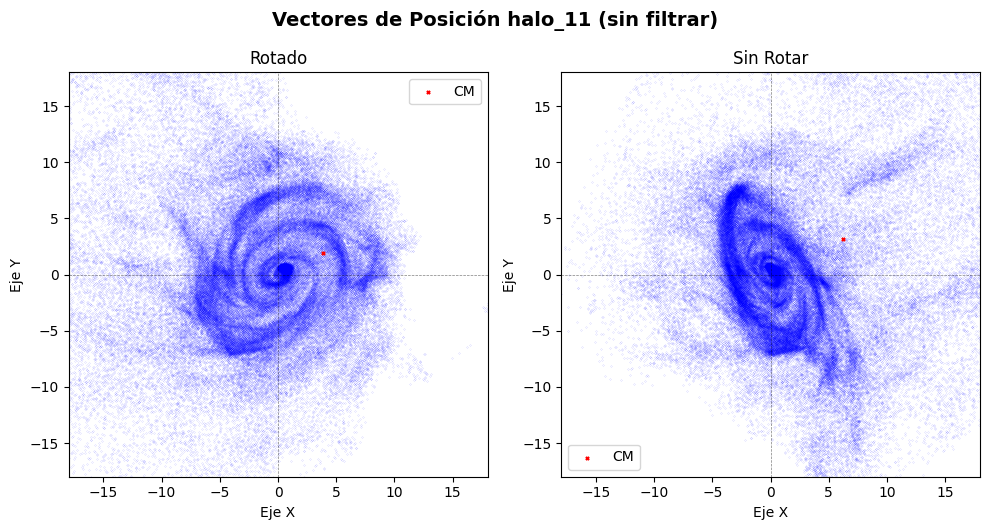

In [9]:
# Seleccionar la dirección de rotación
direction = angular_direction[largest_component]
rotation_handler = RotationHandler(direction)

# Obtener la matriz de rotación según la dirección y componente más grande
angle_rotation_matrix = rotation_handler.choose_rotation_matrix(largest_component, direction)

# Vector a rotar (vector posición)
original_vector_ = simulation.accumulated_data[:, :3]

# Aplicar rotación al vector de posición
rotated_vectors_total = rotation_handler.apply_rotation(angle_rotation_matrix, original_vector_)

# instanciar
visualization = VisualizationHandler()

# Visualizar los vectores rotados
visualization.visualize_galaxy(original_vector_,
                               rotated_vectors_total,
                               center_of_mass_old,
                               center_of_mass,

                               r'Vectores de Posición halo_11 (sin filtrar)')

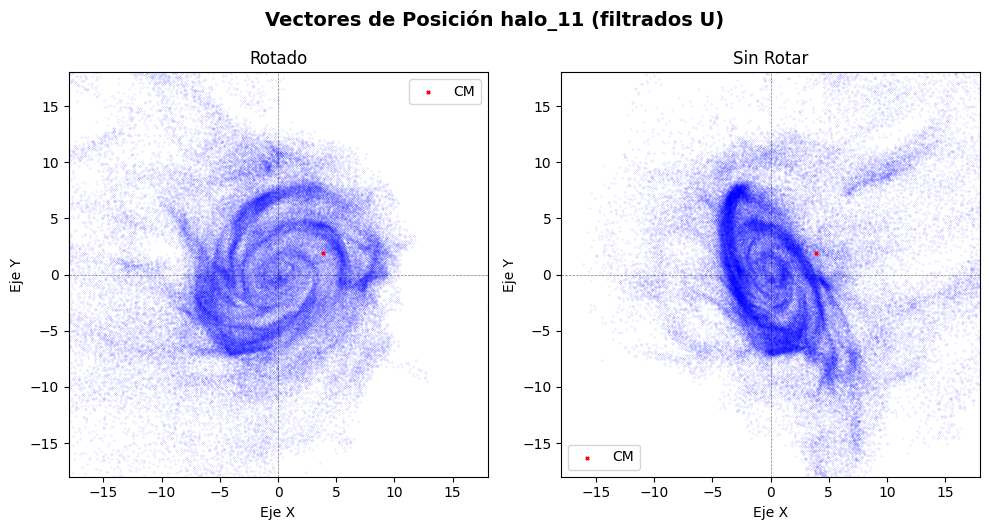

In [10]:
# Aplicar rotación al vector de posición filtrado
rotated_vectors_filtered = rotation_handler.apply_rotation(angle_rotation_matrix, filtered_data[:, :3])

# instanciar
visualization = VisualizationHandler()

# Visualizar los vectores rotados filtrados
visualization.visualize_galaxy(filtered_data,
                               rotated_vectors_filtered,
                               center_of_mass,
                               center_of_mass,

                               r'Vectores de Posición halo_11 (filtrados U)')

##**Análisis del filtro de energía interna.**

In [11]:
print('\n')
print("Centro de Masa(sin filtar) :", center_of_mass_old)
print("Centro de Masa(filtrado) :", center_of_mass)
print('\n')
print("Momento Angular Total(sin filtar) :", total_angular_momentum_old)
print("Momento Angular Total(filtrado) :", total_angular_momentum)
print('\n')
print("La componente más grande del momento angular es:", largest_component, '-- sign --', angular_direction[largest_component])



Centro de Masa(sin filtar) : [ 6.26995005  3.15967993 10.12565415]
Centro de Masa(filtrado) : [3.87421888 1.9062771  6.36505917]


Momento Angular Total(sin filtar) : [86082109.15979192 35382274.72622161 41173971.61054705]
Momento Angular Total(filtrado) : [72073499.20318872 29593868.30224292 33412104.48844868]


La componente más grande del momento angular es: 0 -- sign -- 1.0


In [12]:
formatted_center_of_mass_old = [f"{coord:.3f}" for coord in center_of_mass_old]
print("Centro de Masa (sin filtrar):", formatted_center_of_mass_old)

formatted_center_of_mass = [f"{coord:.3f}" for coord in center_of_mass]
print("Centro de Masa(filtrado):", formatted_center_of_mass)

formatted_total_angular_momentum_old = [f"{momentum:.3f}" for momentum in total_angular_momentum_old]
print("Momento Angular Total (sin filtrar) :", formatted_total_angular_momentum_old)

formatted_total_angular_momentum = [f"{momentum:.3f}" for momentum in total_angular_momentum]
print("Momento Angular Total (filtrado) :", formatted_total_angular_momentum)

Centro de Masa (sin filtrar): ['6.270', '3.160', '10.126']
Centro de Masa(filtrado): ['3.874', '1.906', '6.365']
Momento Angular Total (sin filtrar) : ['86082109.160', '35382274.726', '41173971.611']
Momento Angular Total (filtrado) : ['72073499.203', '29593868.302', '33412104.488']


In [13]:
formatted_largest_component_old = f"{largest_component_old:.0f}"
print("La componente más grande del momento angular (sin filtrar) es:", formatted_largest_component_old, '-- sign --', angular_direction[largest_component_old])

formatted_largest_component = f"{largest_component:.0f}"
print("La componente más grande del momento angular (filtrado) es:", formatted_largest_component, '-- sign --', angular_direction[largest_component])

La componente más grande del momento angular (sin filtrar) es: 0 -- sign -- 1.0
La componente más grande del momento angular (filtrado) es: 0 -- sign -- 1.0


In [14]:
#diferencia centro de masa
center_of_mass_old - center_of_mass


array([2.39573117, 1.25340282, 3.76059499])

In [15]:
#diferencia momentum angular
total_angular_momentum_old - total_angular_momentum

array([14008609.9566032 ,  5788406.4239787 ,  7761867.12209838])

In [16]:

#Error centro de masa ¿cuál es el teorico?
(center_of_mass_old - center_of_mass)/[0.1,0.1,0.1]

array([23.95731167, 12.53402822, 37.60594987])


\begin{array}{|c|c|c|c|}
\hline
\text{Filtro U} & \text{C.M.} & \vec{L} & L_{i}: \text{Largest_component} & \text{#puntos} \\
\hline
\text{Sin filtro} & \text{['6.270', '3.160', '10.126']} & \text{['86082109.160', '35382274.726', '41173971.611']} & \text{0} \\
\text{} & \text{} & \text{} & \text{} \\
\hline
\text{Filtro promedio data} & \text{['2.931', '1.441', '4.564']} & \text{['58935953.677', '24378255.830', '25182324.957']} & \text{0} \\
\text{} & \text{} & \text{} & \text{} \\
\hline
\text{Filtro promedio fabio: 2.78} & \text{['4.430', '2.173', '7.269']} & \text{['75351949.697', '30523441.107', '35321449.517']} & \text{0} \\
\text{} & \text{} & \text{} & \text{} \\
\hline
\text{Filtro promedio de promedios} & \text{['3.874', '1.906', '6.365']} & \text{['72073499.203', '29593868.302', '33412104.488']} & \text{0} \\
\text{} & \text{} & \text{} & \text{} \\
\hline
\end{array}

### Variaciones valor promedio de energía interna


<ipython-input-17-836c47c058da>:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


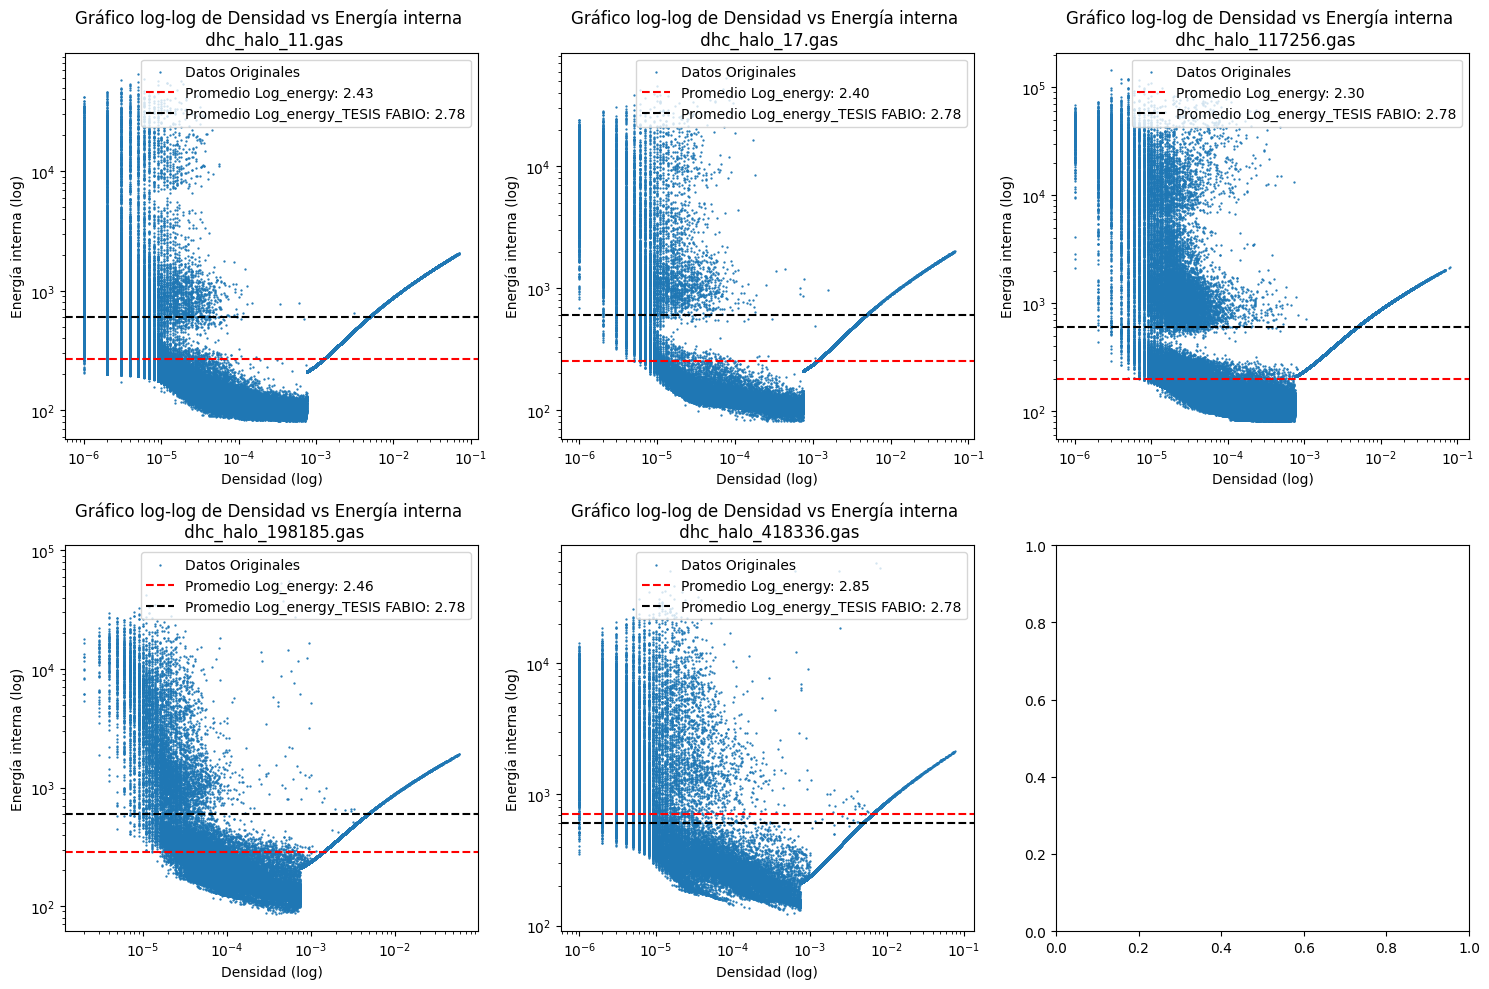

In [17]:
# Ruta de los archivos en tu sistema local
# ruta_archivos = '/ruta/a/tu/carpeta/con/archivos/'

# Nombre de los archivos
halo_files = ['dhc_halo_11.gas', 'dhc_halo_17.gas', 'dhc_halo_117256.gas', 'dhc_halo_198185.gas', 'dhc_halo_418336.gas']

# Cargar cada archivo en un DataFrame de Pandas
archivos_dataframes = [pd.read_csv(archivo, sep=' ', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=None) for archivo in halo_files]

# Definir el número de filas y columnas para los subplots
filas = 2
columnas = 3

fig, axs = plt.subplots(filas, columnas, figsize=(15, 10))

# Gráficos para cada archivo
for i, df in enumerate(archivos_dataframes):
    # Obtener los datos x e y del DataFrame
    x = df['rho']
    y = df['U']

    # Calcular el promedio de Log_energy
    Log_energy = np.log10(df['U'])
    avg_energy = np.mean(Log_energy)

    # Calcular la posición en los subplots
    fila = i // columnas
    columna = i % columnas

    # Graficar en escala log-log
    axs[fila, columna].scatter(x, y, s=0.4, label='Datos Originales')
    axs[fila, columna].axhline(y=10**avg_energy, color='r', linestyle='--', label=f'Promedio Log_energy: {avg_energy:.2f}')
    axs[fila, columna].axhline(y=10**2.78, color='k', linestyle='--', label=f'Promedio Log_energy_TESIS FABIO: 2.78')

    axs[fila, columna].set_xscale('log')
    axs[fila, columna].set_yscale('log')
    axs[fila, columna].set_xlabel('Densidad (log)')
    axs[fila, columna].set_ylabel('Energía interna (log)')
    axs[fila, columna].set_title(f'Gráfico log-log de Densidad vs Energía interna \n {halo_files[i]}')
    axs[fila, columna].legend()

plt.tight_layout()
plt.show();


Promedio

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


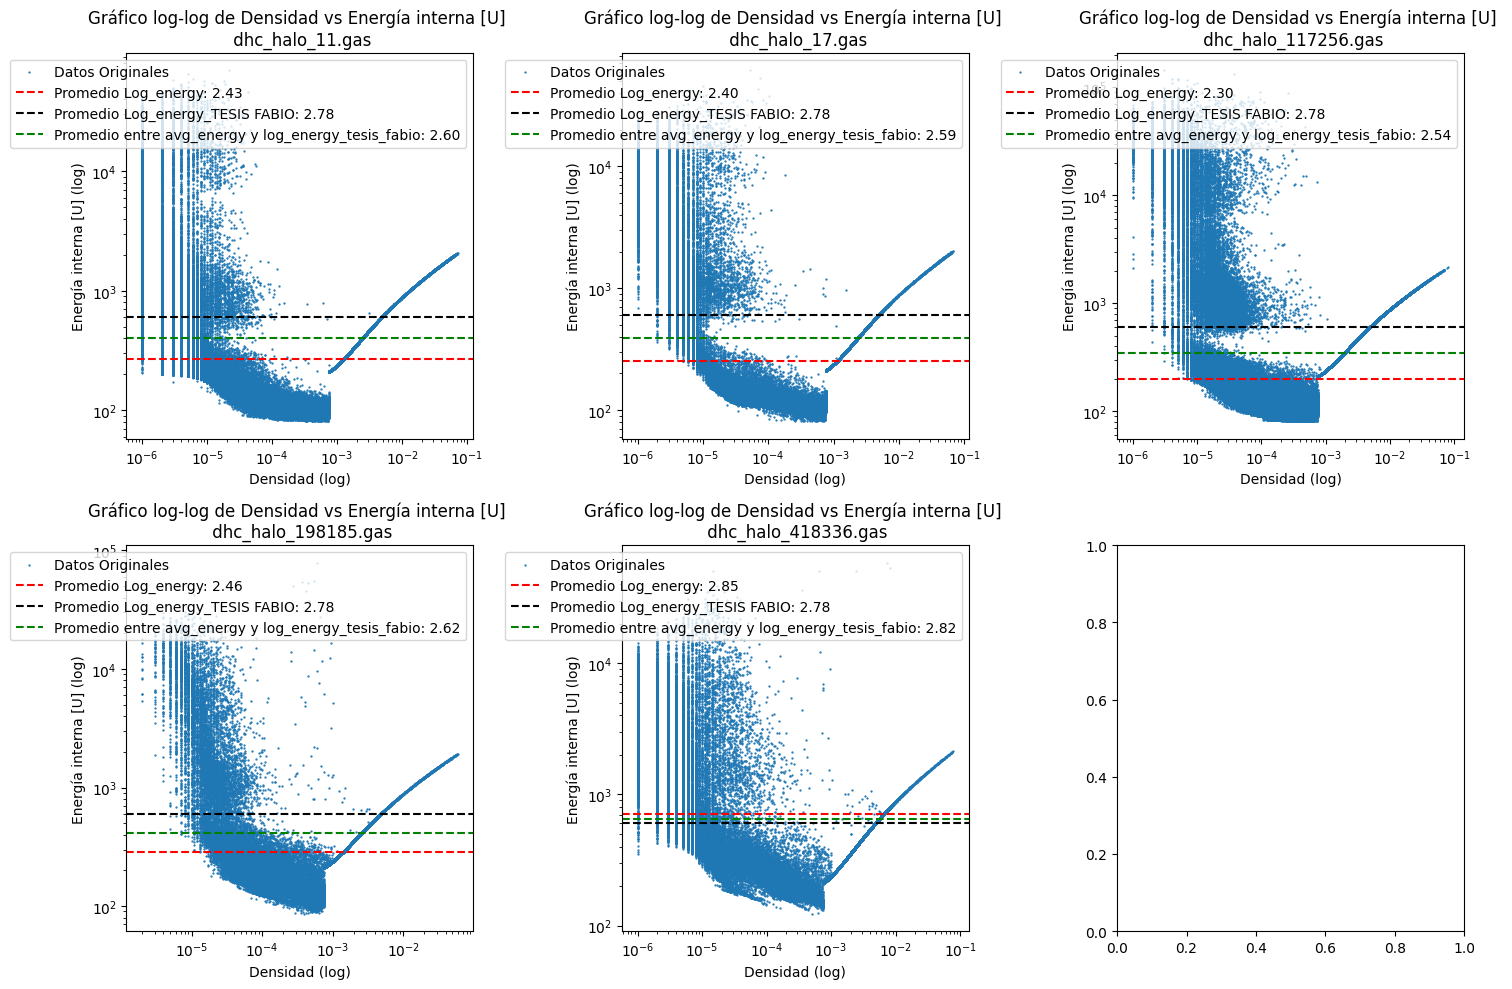

In [18]:
# Nombre de los archivos
halo_files = ['dhc_halo_11.gas', 'dhc_halo_17.gas', 'dhc_halo_117256.gas', 'dhc_halo_198185.gas', 'dhc_halo_418336.gas']

# Cargar cada archivo
archivos_dataframes = [pd.read_csv(archivo, sep=' ', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=None) for archivo in halo_files]

# Definir filas y columnas para los subplots
filas = 2
columnas = 3

fig, axs = plt.subplots(filas, columnas, figsize=(15, 10))

promedios = []
for i, df in enumerate(archivos_dataframes):

    x = df['rho']
    y = df['U']

    # Calcular el promedio de Log_energy
    Log_energy = np.log10(df['U'])
    avg_energy = np.mean(Log_energy)
    log_energy_tesis_fabio = 2.78

    # Calcular el promedio entre avg_energy y log_energy_tesis_fabio
    promedio = (avg_energy + log_energy_tesis_fabio) / 2
    promedios.append(promedio)

    # posición en los subplots
    fila = i // columnas
    columna = i % columnas

    # Graficar en escala log-log
    axs[fila, columna].scatter(x, y, s=0.4, label='Datos Originales')
    axs[fila, columna].axhline(y=10**avg_energy, color='r', linestyle='--', label=f'Promedio Log_energy: {avg_energy:.2f}')
    axs[fila, columna].axhline(y=10**2.78, color='k', linestyle='--', label=f'Promedio Log_energy_TESIS FABIO: 2.78')
    axs[fila, columna].axhline(y=10**promedio, color='g', linestyle='--', label=f'Promedio entre avg_energy y log_energy_tesis_fabio: {promedio:.2f}')

    axs[fila, columna].set_xscale('log')
    axs[fila, columna].set_yscale('log')
    axs[fila, columna].set_xlabel('Densidad (log)')
    axs[fila, columna].set_ylabel('Energía interna [U] (log)')
    axs[fila, columna].set_title(f'Gráfico log-log de Densidad vs Energía interna [U] \n {halo_files[i]}')
    axs[fila, columna].legend()

plt.tight_layout();
plt.show();


In [19]:
#simulation.visualize_3d_comparison(rotated_vectors, 'Vectores de Posición Rotados', original_vector, 'Vectores de Posición Originales')


## ConvexHull   
### $\left\langle \text{ log}(U) \right\rangle = 2.63$



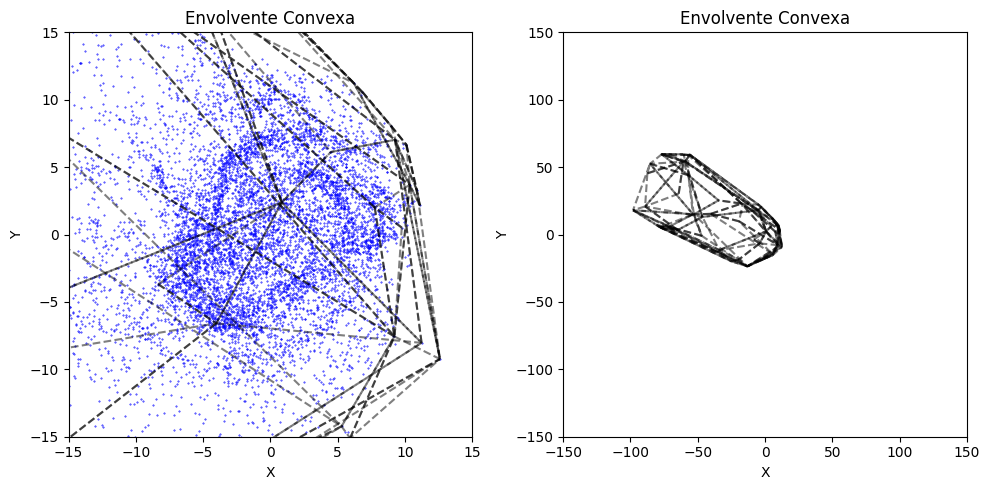

In [49]:
#-----------------------------usando scipy------------------------------
from scipy.spatial import ConvexHull
#-----------------------------------------------------------------------

x = rotated_vectors_filtered[:, 0]
y = rotated_vectors_filtered[:, 1]
z = rotated_vectors_filtered[:, 2]
points_3d = np.vstack((x, y, z)).T

# Elegir un número pequeño de puntos aleatorios por coordenada
n_points_per_coord = 10000
sample_indices = np.random.choice(points_3d.shape[0], n_points_per_coord, replace=False)
sample_points = points_3d[sample_indices]

# Calcular la envolvente convexa
hull_3d = ConvexHull(sample_points)

# Calcular la teselación de Voronoi para la muestra de puntos
voronoi_sample = VoronoiTess(sample_points)
vertices_voronoi = np.array(voronoi_sample.vertices)  # Convertir a NumPy array
regions_voronoi = voronoi_sample.regions

#figura
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Teselación de Voronoi en el primer subgráfico
for region in regions_voronoi:
    polygon = [vertices_voronoi[i] for i in region]
    #axs[0].fill(*zip(*polygon), alpha=0.15)

# Envolvente convexa en el primer subgráfico
for simplex in hull_3d.simplices:
    axs[0].plot(sample_points[simplex, 0], sample_points[simplex, 1], 'k--', alpha=0.5)

# Graficar los puntos generados en el primer subgráfico
axs[0].scatter(sample_points[:, 0], sample_points[:, 1], color='blue', marker='o', s=0.15)
axs[0].set_title('Envolvente Convexa')
axs[0].set_xlim(-15, 15)
axs[0].set_ylim(-15, 15)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Graficar solo la envolvente convexa en el segundo subgráfico
for simplex in hull_3d.simplices:
    axs[1].plot(sample_points[simplex, 0], sample_points[simplex, 1], 'k--', alpha=0.5)

axs[1].set_title('Envolvente Convexa')
axs[1].set_xlim(-150, 150)
axs[1].set_ylim(-150, 150)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()


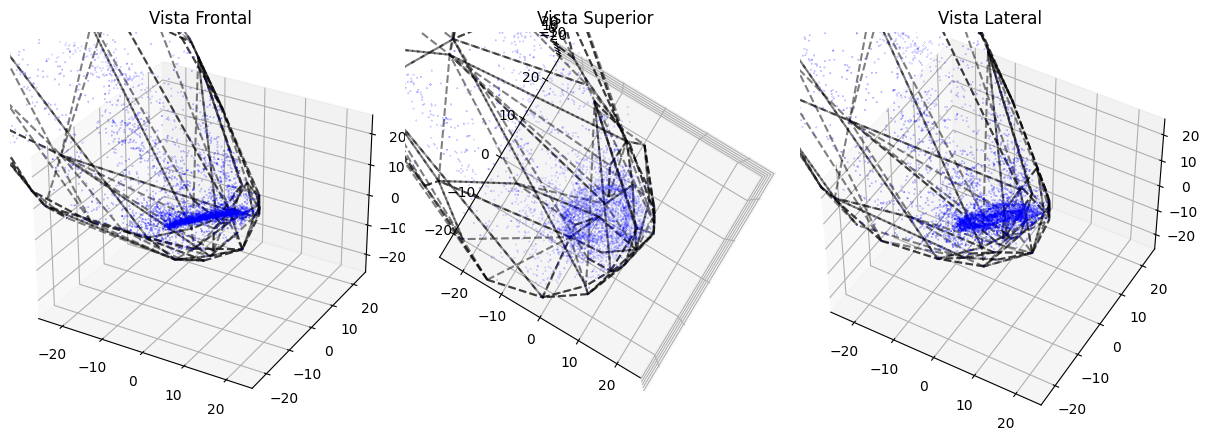

In [47]:
from mpl_toolkits.mplot3d import Axes3D

# Definir los puntos en 3D
x = rotated_vectors_filtered[:, 0]
y = rotated_vectors_filtered[:, 1]
z = rotated_vectors_filtered[:, 2]
points_3d = np.vstack((x, y, z)).T

# Elegir un número pequeño de puntos aleatorios por coordenada
n_points_per_coord = 5000
sample_indices = np.random.choice(points_3d.shape[0], n_points_per_coord, replace=True)
sample_points = points_3d[sample_indices]

# Calcular la envolvente convexa
hull_3d = ConvexHull(sample_points)

# Crear la figura en 3D
fig = plt.figure(figsize=(12, 8))

# Subplot 1: Vista desde el frente
ax1 = fig.add_subplot(131, projection='3d')
for region in regions_voronoi:
    polygon = [vertices_voronoi[i] for i in region]
    #ax1.plot(*zip(*polygon), alpha=0.15)
for simplex in hull_3d.simplices:
    ax1.plot(sample_points[simplex, 0], sample_points[simplex, 1], sample_points[simplex, 2], 'k--', alpha=0.5)
ax1.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='blue', marker='o', s=0.03)
ax1.set_title('Vista Frontal')
ax1.set_xlim(-25,25)
ax1.set_ylim(-25,25)
ax1.set_zlim(-25,25)
ax1.view_init(30)

# Subplot 2: Vista desde arriba
ax2 = fig.add_subplot(132, projection='3d')
for region in regions_voronoi:
    polygon = [vertices_voronoi[i] for i in region]
    #ax2.plot(*zip(*polygon), alpha=0.15)
for simplex in hull_3d.simplices:
    ax2.plot(sample_points[simplex, 0], sample_points[simplex, 1], sample_points[simplex, 2], 'k--', alpha=0.5)
ax2.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='blue', marker='o', s=0.03)
ax2.set_title('Vista Superior')
ax2.set_xlim(-25,25)
ax2.set_ylim(-25,25)
ax2.set_zlim(-25,25)
ax2.view_init(90)

# Subplot 3: Vista desde el lado
ax3 = fig.add_subplot(133, projection='3d')
for region in regions_voronoi:
    polygon = [vertices_voronoi[i] for i in region]
    #ax3.plot(*zip(*polygon), alpha=0.15)
for simplex in hull_3d.simplices:
    ax3.plot(sample_points[simplex, 0], sample_points[simplex, 1], sample_points[simplex, 2], 'k--', alpha=0.5)
ax3.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='blue', marker='o', s=0.03)
ax3.set_title('Vista Lateral')
ax3.set_xlim(-25,25)
ax3.set_ylim(-25,25)
ax3.set_zlim(-25,25)
ax3.view_init(45)
plt.tight_layout()
plt.show()


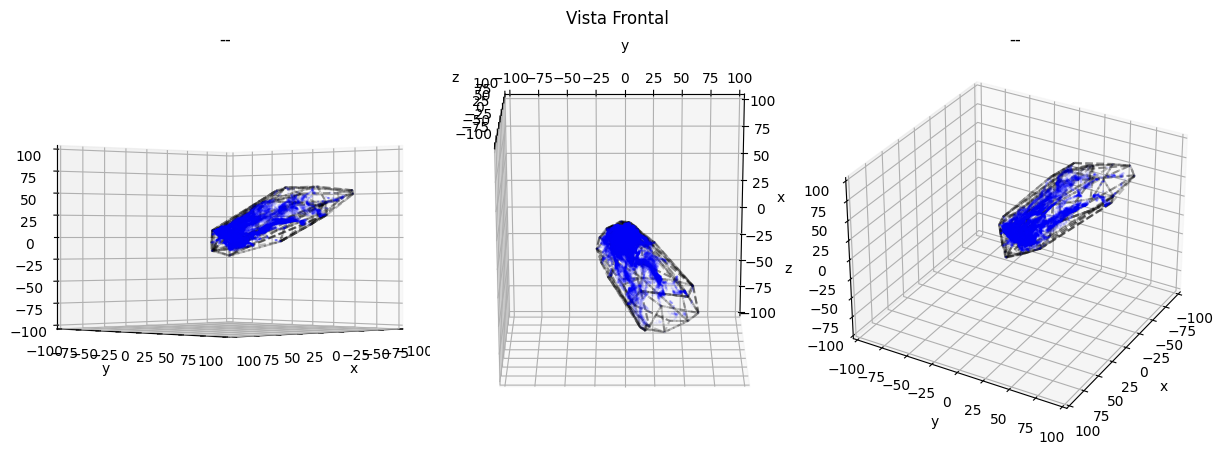

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyhull.voronoi import VoronoiTess

# Definir los puntos en 3D
x = rotated_vectors_filtered[:, 0]
y = rotated_vectors_filtered[:, 1]
z = rotated_vectors_filtered[:, 2]
points_3d = np.vstack((x, y, z)).T

# Elegir un número pequeño de puntos aleatorios por coordenada
##n_points_per_coord = 10000
#sample_indices = np.random.choice(points_3d.shape[0], n_points_per_coord, replace=True)
#points_3d = points_3d[sample_indices]

# Calcular la envolvente convexa
hull_3d = ConvexHull(points_3d)

# Crear la figura en 3D
fig = plt.figure(figsize=(12, 8))

# Subplot 1: Vista desde el frente
ax1 = fig.add_subplot(131, projection='3d')
for simplex in hull_3d.simplices:
    ax1.plot(points_3d[simplex, 0], points_3d[simplex, 1], points_3d[simplex, 2], 'k--', alpha=0.25)
ax1.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], color='blue', marker='o', s=0.003)
ax1.set_title('--')
ax1.set_xlim(-100,100)
ax1.set_ylim(-100,100)
ax1.set_zlim(-100,100)
ax1.view_init(0,45)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Subplot 2: Vista desde arriba
ax2 = fig.add_subplot(132, projection='3d')
for simplex in hull_3d.simplices:
    ax2.plot(points_3d[simplex, 0], points_3d[simplex, 1], points_3d[simplex, 2], 'k--', alpha=0.25)
ax2.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], color='blue', marker='o', s=0.003)
ax2.set_title('Vista Frontal \n')
ax2.set_xlim(-100,100)
ax2.set_ylim(-100,100)
ax2.set_zlim(-100,100)
ax2.view_init(-70,360)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

# Subplot 3: Vista desde el lado
ax3 = fig.add_subplot(133, projection='3d')

for simplex in hull_3d.simplices:
    ax3.plot(points_3d[simplex, 0], points_3d[simplex, 1], points_3d[simplex, 2], 'k--', alpha=0.25)
ax3.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], color='blue', marker='o', s=0.003)
ax3.set_title('--')
ax3.set_xlim(-100,100)
ax3.set_ylim(-100,100)
ax3.set_zlim(-100,100)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.view_init(30,30)
plt.tight_layout()
plt.show()


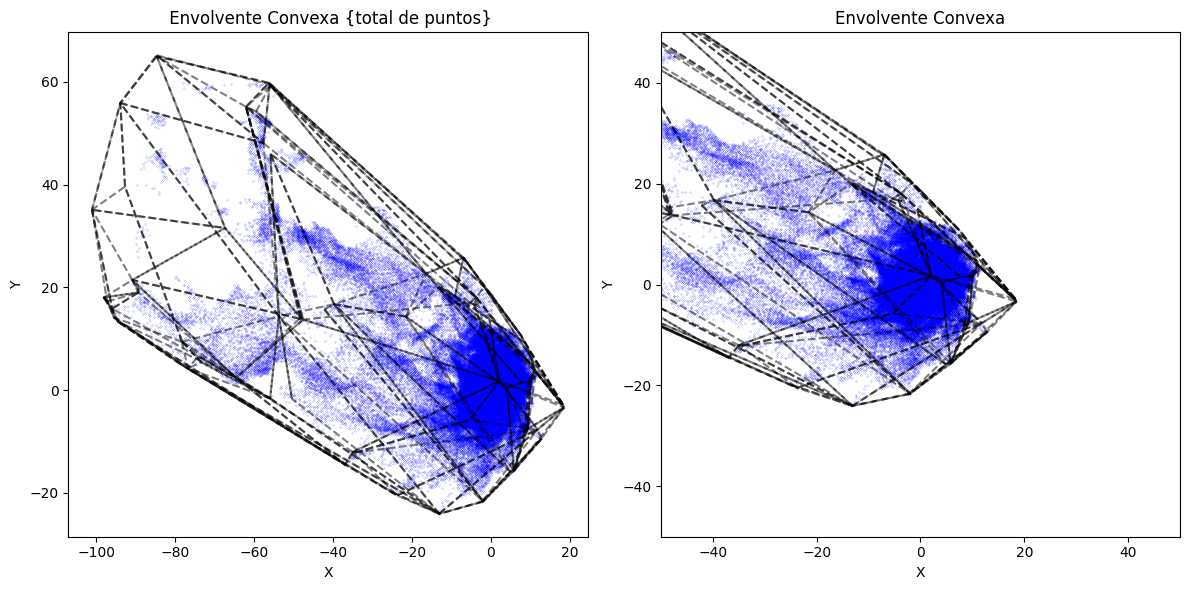

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from pyhull.voronoi import VoronoiTess

x = rotated_vectors_filtered[:, 0]
y = rotated_vectors_filtered[:, 1]
z = rotated_vectors_filtered[:, 2]
points_3d = np.vstack((x, y, z)).T

#-------------------------------------------------------
#----------------TOTAL DE PUNTOS ------------------------
#--------------------------------------------------------
# Elegir un número pequeño de puntos aleatorios por coordenada
#n_points_per_coord = len()
#sample_indices = np.random.choice(points_3d.shape[0], n_points_per_coord, replace=False)
#sample_points = points_3d[sample_indices]

# Calcular la envolvente convexa
hull_3d = ConvexHull(points_3d)

# Crear una figura con dos subgráficos en una fila
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficar la envolvente convexa en el primer subgráfico
for simplex in hull_3d.simplices:
    axs[0].plot(points_3d[simplex, 0], points_3d[simplex, 1], 'k--', alpha=0.5)

# Graficar los puntos generados en el primer subgráfico
axs[0].scatter(points_3d[:, 0], points_3d[:, 1], color='blue', marker='o', s=0.015)  # s=0.003

# Configuración del primer subgráfico
axs[0].set_title(' Envolvente Convexa {total de puntos}')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Graficar solo la envolvente convexa en el segundo subgráfico
for simplex in hull_3d.simplices:
    axs[1].plot(points_3d[simplex, 0], points_3d[simplex, 1], 'k--', alpha=0.5)

axs[1].scatter(points_3d[:, 0], points_3d[:, 1], color='blue', marker='o', s=0.015)  # s=0.003

# Configuración del segundo subgráfico,
axs[1].set_title('Envolvente Convexa')
axs[1].set_xlim(-50, 50)
axs[1].set_ylim(-50, 50)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()


## Data Structures

Qhull produces the following data structures for dimension d:

- A **_coordinate_** is a real number in floating point format.
- A **_point_** is an array of d coordinates. With option 'QJ', the coordinates are joggled by a small amount.
- A **_vertex_** is an input point.
- A **_hyperplane_** is d normal coefficients and an offset. The length of the normal is one.

The hyperplane defines a halfspace. If V is a normal, b is an offset, and x is a point inside the convex hull, then $Vx+b < 0$.
- An **_outer plane_** is a positive offset from a hyperplane. When Qhull is done, all points will be below all outer planes.
- An **_inner plane_** is a negative offset from a hyperplane. When Qhull is done, all vertices will be above the corresponding inner planes.
- An **_orientation_** is either 'top' or 'bottom'. It is the topological equivalent of a hyperplane's geometric orientation.
- A **_simplicial facet_** is a set of d neighboring facets, a set of d vertices, a hyperplane equation, an inner plane, an outer plane, and an orientation. For example in 3-d, a simplicial facet is a triangle.
- A **_centrum_** is a point on a facet's hyperplane. A centrum is the average of a facet's vertices. Neighboring facets are convex if each centrum is below the neighbor facet's hyperplane.


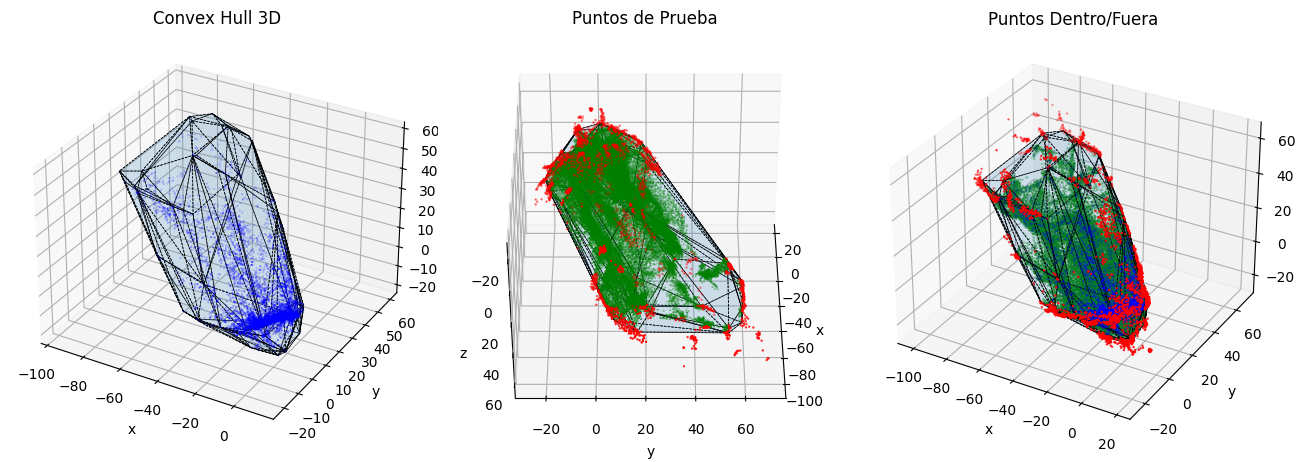

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Definir los puntos en 3D
x = rotated_vectors_filtered[:, 0]
y = rotated_vectors_filtered[:, 1]
z = rotated_vectors_filtered[:, 2]
points_3d = np.vstack((x, y, z)).T


# Definir los puntos en 3D
x_ = rotated_vectors_total[:, 0]
y_ = rotated_vectors_total[:, 1]
z_ = rotated_vectors_total[:, 2]
points_3d_datos = np.vstack((x_, y_, z_)).T

# Elegir un número pequeño de puntos aleatorios por coordenada
n_points_per_coord = 10000
sample_indices = np.random.choice(points_3d.shape[0], n_points_per_coord, replace=True)
sample_points = points_3d[sample_indices]

# Calcular la envolvente convexa
hull_3d = ConvexHull(sample_points)

# Crear una malla de puntos para visualizar la superficie del Convex Hull
x_min, x_max = np.min(sample_points[:, 0]), np.max(sample_points[:, 0])
y_min, y_max = np.min(sample_points[:, 1]), np.max(sample_points[:, 1])
z_min, z_max = np.min(sample_points[:, 2]), np.max(sample_points[:, 2])
x_mesh, y_mesh, z_mesh = np.meshgrid(np.linspace(x_min, x_max, 50),
                                     np.linspace(y_min, y_max, 50),
                                     np.linspace(z_min, z_max, 50))
mesh_points = np.vstack((x_mesh.flatten(), y_mesh.flatten(), z_mesh.flatten())).T


# Verificar si los puntos de prueba están dentro del Convex Hull
def puntos_prueba_dentro(hull, puntos):
    # Transformar los puntos de prueba al espacio del Convex Hull
    puntos_transformados = hull.equations[:, :-1].dot(puntos.T) + hull.equations[:, -1][:, np.newaxis]
    # Verificar si los puntos están detrás de cada plano del Convex Hull
    esta_dentro = np.all(puntos_transformados <= 0, axis=0)
    return esta_dentro

# Generar puntos de prueba adicionales
n_puntos_prueba = 300
puntos_prueba = np.random.uniform(low=[x_min, y_min, z_min], high=[x_max, y_max, z_max], size=(n_puntos_prueba, 3))

# Verificar qué puntos de prueba están dentro del Convex Hull
esta_dentro_hull = puntos_prueba_dentro(hull_3d, points_3d_datos)

# Visualizar el Convex Hull y los puntos de prueba
fig = plt.figure(figsize=(13, 10))

# Subplot 1: Vista desde el frente
ax1 = fig.add_subplot(131, projection='3d')
ax1.add_collection(Poly3DCollection(sample_points[hull_3d.simplices], alpha=0.1, linewidths=0.5, edgecolors='k', linestyle='--' ))
ax1.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='blue', s=0.03)
ax1.set_title('Convex Hull 3D')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')


# Subplot 2: Vista desde arriba
ax2 = fig.add_subplot(132, projection='3d')
ax2.add_collection(Poly3DCollection(sample_points[hull_3d.simplices], alpha=0.1, linewidths=0.5, edgecolors='k',  linestyle='--'))
ax2.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='blue', s=0.03)
ax2.scatter(points_3d_datos[esta_dentro_hull][:, 0], points_3d_datos[esta_dentro_hull][:, 1], points_3d_datos[esta_dentro_hull][:, 2], color='green', s=0.10)
ax2.scatter(points_3d_datos[~esta_dentro_hull][:, 0], points_3d_datos[~esta_dentro_hull][:, 1], points_3d_datos[~esta_dentro_hull][:, 2], color='red', s=0.50)
ax2.set_title('Puntos de Prueba')
ax2.view_init(220,360)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

# Subplot 3: Vista desde el lado
ax3 = fig.add_subplot(133, projection='3d')
ax3.add_collection(Poly3DCollection(sample_points[hull_3d.simplices], alpha=0.1, linewidths=0.5, edgecolors='k',  linestyle='--'))
ax3.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2], color='blue', s=0.03)
ax3.scatter(points_3d_datos[esta_dentro_hull][:, 0], points_3d_datos[esta_dentro_hull][:, 1], points_3d_datos[esta_dentro_hull][:, 2], color='green', s=0.10)
ax3.scatter(points_3d_datos[~esta_dentro_hull][:, 0], points_3d_datos[~esta_dentro_hull][:, 1], points_3d_datos[~esta_dentro_hull][:, 2], color='red', s=0.50)
ax3.set_title('Puntos Dentro/Fuera')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.tight_layout()
plt.show()


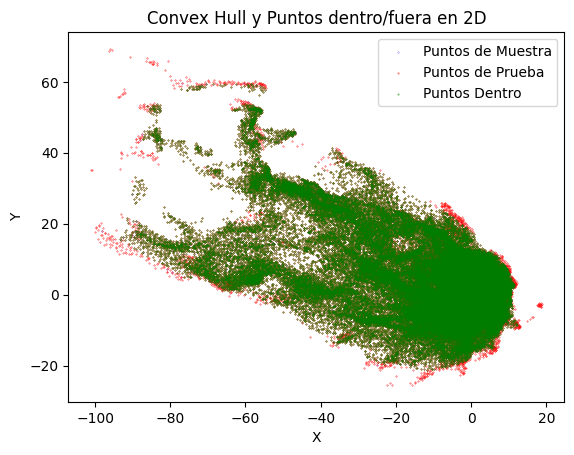

In [58]:
# Graficar los puntos de muestra y los puntos de prueba en 2D
plt.scatter(sample_points[:, 0], sample_points[:, 1], color='blue', label='Puntos de Muestra', s=0.03)
#plt.scatter(points_3d[:, 0], points_3d[:, 1], color='gray', label='Puntos de Muestra filtrados', s=0.03, alpha=0.3)
#plt.scatter(points_3d_datos[:, 0], points_3d_datos[:, 1], color='black', label='Puntos de Muestra sin filtrar', s=0.03, alpha=0.3)

plt.scatter(points_3d_datos[:, 0], points_3d_datos[:, 1], color='red', label='Puntos de Prueba', s=0.08)
plt.scatter(points_3d_datos[esta_dentro_hull][:, 0], points_3d_datos[esta_dentro_hull][:, 1], color='green', label='Puntos Dentro', s=0.08)
plt.legend()
plt.title('Convex Hull y Puntos dentro/fuera en 2D')
plt.xlabel('X')
plt.ylabel('Y')
plt.show();

